# Vehicle registration plate recognition
## Final project
## Selyutin Vadim, Uspenskaia Natalia

### Problem description
Massive integration of information technologies under different aspects of the modern world has led to the treatment of vehicles as conceptual resources in information systems. License plate recognition is one of the important security measurements, reinforcing the transportation laws and car-tracing.
Although this technique is already used by government it is still interesting to implement it by yourself.

### CV pipeline
Our goal is to recognize symbols on a registration plate. We can highlight 3 main steps of our project:
- recognition of the plate frame,
- detection of plate symbols,
- recognition of specific symbols.

For the first step we've applied two approaches:
- find the biggest contour,
- find 4-corners closed contour.

To detect a frame and its symbols we use Canny edge detector on the normalized image, detect biggest contours and find their rectangular boundary. Finally, recognition of specific symbol is done via 3 methods:
- correlation comparison of symbol and template,
- HOG feature description and applying Linear Support Vector Classifier classifier,
- applying to the normalized plate frame Pytesseract.

In [1]:
import cv2
import imutils
import numpy as np
import pytesseract
from PIL import Image
from skimage import io
from skimage.feature import canny
import matplotlib.pyplot as plt
import os
import warnings
warnings.filterwarnings("ignore")
import string
from skimage.transform import rescale
import pandas as pd
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_predict, KFold
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score
from skimage.feature import match_template

# Dataset description
http://www.zemris.fer.hr/projects/LicensePlates/english/results.shtml

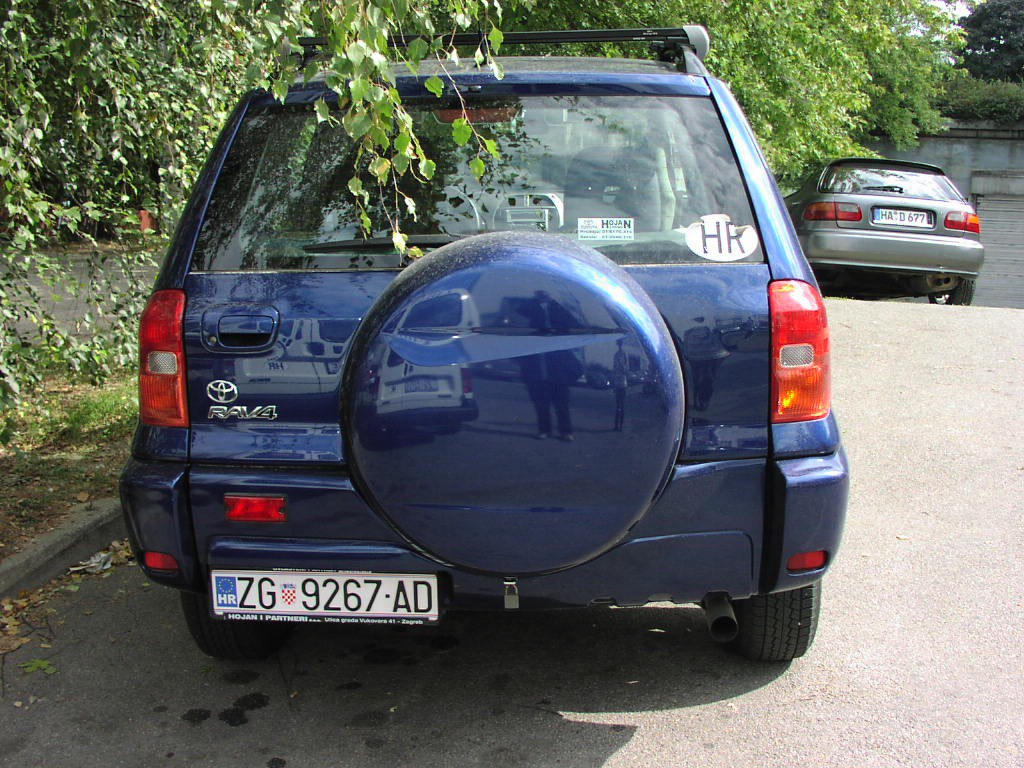

In [2]:
from IPython.display import Image
Image("example.jpg")

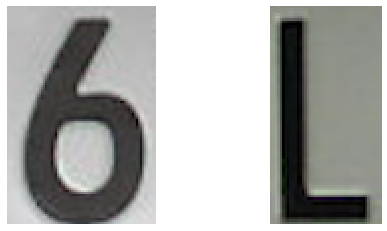

(<matplotlib.axes._subplots.AxesSubplot at 0x126e7d9e8>,
 <matplotlib.axes._subplots.AxesSubplot at 0x126f2ff28>)

In [3]:
def show2(image1, image2):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
    ax1.imshow(image1)
    ax2.imshow(image2)
    ax1.axis('off')
    ax2.axis('off')
    plt.show() 
    return ax1, ax2


image1 = cv2.imread('example1.png')  
image2 = cv2.imread('example2.png')
show2(image1, image2)

# 0. Baseline strategy

In [4]:
def baseline_read_img(img_name):
    image_full = io.imread(img_name, as_gray=True, plugin='matplotlib')
    image_scaled= rescale(image_full, 0.5)
    io.imshow(image_scaled)
    return image_scaled


def baseline_plate_contour(image_scaled):
    edges = canny(image_scaled)
    edges = (edges).astype(np.uint8)
    ext_contours = cv2.findContours(edges.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[1]
    contour = max(ext_contours, key=cv2.contourArea)
    contour = contour.squeeze()
    epsilon = 0.018 * cv2.arcLength(contour, True)
    corners = cv2.approxPolyDP(contour, epsilon, True).squeeze()
    src = np.array(corners, dtype='float32')
    fig, ax = plt.subplots()
    ax.imshow(image_scaled)
    ax.plot(contour[:, 0], contour[:,  1], 'r')
    plt.show()
    return src, corners


def baseline_normalize_plate(src, corners):
    def distance(p1, p2):
        a = p2[0] - p1[0]
        b = p2[1] - p1[1]
        return np.sqrt((a ** 2) + (b ** 2))


    src_middle_x = sum([el[0] for el in src]) / 4
    src_middle_y = sum([el[1] for el in src]) / 4

    for point in src:
        if (point[0] > src_middle_x) and (point[1] > src_middle_y):
            lower_right = point
        if (point[0] < src_middle_x) and (point[1] < src_middle_y):
            upper_left = point
        if (point[0] > src_middle_x) and (point[1] < src_middle_y):
            lower_left = point
        if (point[0] < src_middle_x) and (point[1] > src_middle_y):
            upper_right = point

    src = np.array([lower_left, upper_left, upper_right, lower_right], dtype='float32')

    side1 = max([distance(corners[3], corners[0]),
                distance(corners[1], corners[2]),
                distance(corners[3], corners[2]),
                distance(corners[1], corners[0])])
    side2 = min([distance(corners[3], corners[0]),
                distance(corners[1], corners[2]),
                distance(corners[3], corners[2]),
                distance(corners[1], corners[0])])

    dst = np.array([[side1, 0], [0, 0], [0, side2],  [side1, side2]], dtype='float32')
    m = cv2.getPerspectiveTransform(src, dst)
    normalized_image = cv2.warpPerspective(image_scaled, m, (int(side1), int(side2)))
    io.imshow(normalized_image)
    return normalized_image


def baseline_find_symbols(normalized_image):
    normalized_image = cv2.threshold(normalized_image,0.4,0.9,cv2.THRESH_BINARY)[1]
    edges = canny(normalized_image)
    edges = (edges).astype(np.uint8)
    symbols_contours = cv2.findContours(edges.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[1]

    candidates_lst = []
    candidates_coordinate = []

    biggest_contours = sorted(symbols_contours, key=lambda x: cv2.contourArea(x), reverse=True)[:6]
    for c in biggest_contours:
        x,y,w,h = cv2.boundingRect(c)
        candidates_coordinate.append(x)
        candidates_lst.append(normalized_image[y:y+h,x:x+w])
    return candidates_lst, candidates_coordinate


def baseline_recognize_symbols(candidates_lst, candidates_coordinate):
    letters_lst = ['а', 'у', 'к', 'х', 'м', 'о', 'с', 'в', 'р', 'е', 'н']
    digits_lst = np.arange(0, 10)
    recognized_symbols = []


    def match_value(image_1, image_2):
        result = match_template(image_1, image_2)
        min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(result)
        return max(max_val, abs(min_val))


    for candidate in candidates_lst:
        max_match_value = -100
        resized_candidate = cv2.resize(candidate, (100, 100))
        resized_candidate = cv2.threshold(resized_candidate,0.8,0.9,cv2.THRESH_BINARY)[1]

        for digit in digits_lst:
            template = cv2.imread('./digits/{}.png'.format(digit), cv2.IMREAD_GRAYSCALE)
            template = cv2.resize(template, (100, 100))
            match = match_value(resized_candidate, template)
            if match > max_match_value:
                best_candidate = digit
                max_match_value = match

        for ind, letter in enumerate(letters_lst):
            template = cv2.imread('./letters/{}.png'.format(ind), cv2.IMREAD_GRAYSCALE)
            template = cv2.resize(template, (100, 100))
            match = match_value(resized_candidate, template)
            if match > max_match_value:
                best_candidate = letters_lst[ind]
                max_match_value = match        

        if max_match_value >= 0.4:
            recognized_symbols.append(best_candidate)
        else:
            recognized_symbols.append('not recognized')

    recognized_symbols = np.array(recognized_symbols)
    return recognized_symbols[np.argsort(candidates_coordinate)]

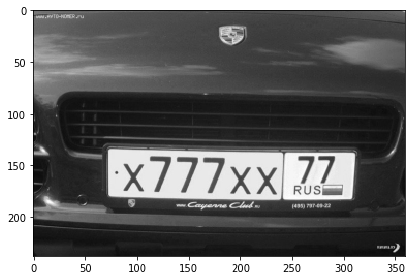

In [5]:
img_name = './random_cars/car0.jpg'
image_scaled = baseline_read_img(img_name)

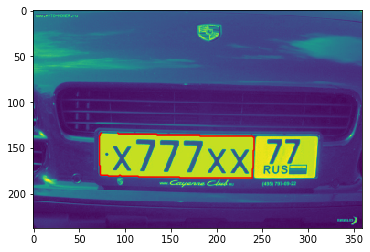

In [6]:
src, corners = baseline_plate_contour(image_scaled)

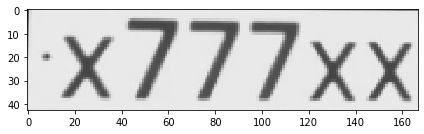

In [7]:
normalized_image = baseline_normalize_plate(src, corners)

In [8]:
candidates_lst, candidates_coordinate = baseline_find_symbols(normalized_image)
recognized_symbols = baseline_recognize_symbols(candidates_lst, candidates_coordinate)
print(recognized_symbols)

['х' '7' '7' '7' 'х' 'х']


# 1. Read and preprocess image

In [9]:
def read_and_preprocess_img(img_name, draw_result=True):
    img = cv2.imread(img_name, cv2.IMREAD_COLOR)
    # img = cv2.imread('./random_cars/car13.jpg',cv2.IMREAD_COLOR)
    img = cv2.resize(img, (620,480))
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_gray = cv2.bilateralFilter(img_gray, 11, 17, 17)
    if draw_result:
        io.imshow(img)
    return img_gray, img

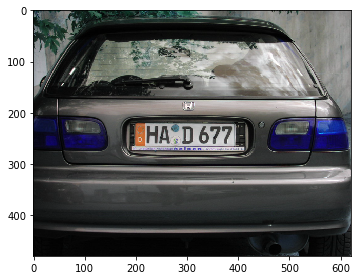

In [10]:
img_name = './baza_slika/170902/P9170019.jpg'
# img_name = './random_cars/car13.jpg'

img_gray, img = read_and_preprocess_img(img_name)

# 2. License plate detection

In [11]:
def detect_plate_contour(img_gray, img, draw_result=True):
    edges = cv2.Canny(img_gray, 30, 200)

    contours_lst = cv2.findContours(edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contours_lst = imutils.grab_contours(contours_lst)
    contours_lst = sorted(contours_lst, key = cv2.contourArea, reverse = True)[:10]

    plate_contour = None
    for c in contours_lst:
        epsilon = 0.018 * cv2.arcLength(c, True)
        corners = cv2.approxPolyDP(c, epsilon, True)

        if len(corners) == 4:
            plate_contour = corners
            break

    if plate_contour is None:
        print('Plate not found :(')
    else:
        print('Cool!!! I found something!')
        if draw_result:
            io.imshow(cv2.drawContours(img.copy(), [plate_contour], -1, (255, 0, 0), 3))
    return plate_contour

Cool!!! I found something!


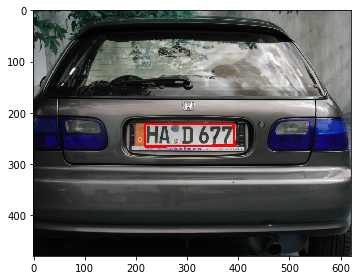

In [12]:
plate_contour = detect_plate_contour(img_gray, img)

# 3. Image normalization

In [13]:
def transform_image(plate_contour, img_gray, draw_result=True):
    def distance(p1, p2):
        a = p2[0] - p1[0]
        b = p2[1] - p1[1]
        return np.sqrt((a ** 2) + (b ** 2))
    
    corners = plate_contour[:, 0, :]
    src = np.array(corners, dtype='float32')

    src_middle_x = sum([el[0] for el in src]) / 4
    src_middle_y = sum([el[1] for el in src]) / 4

    for point in src:
        if (point[0] > src_middle_x) and (point[1] > src_middle_y):
            lower_right = point
        if (point[0] < src_middle_x) and (point[1] < src_middle_y):
            upper_left = point
        if (point[0] > src_middle_x) and (point[1] < src_middle_y):
            lower_left = point
        if (point[0] < src_middle_x) and (point[1] > src_middle_y):
            upper_right = point

    src = np.array([lower_left, upper_left, upper_right, lower_right], dtype='float32')

    side1 = max([distance(corners[3], corners[0]),
                distance(corners[1], corners[2]),
                distance(corners[3], corners[2]),
                distance(corners[1], corners[0])])

    side2 = min([distance(corners[3], corners[0]),
                distance(corners[1], corners[2]),
                distance(corners[3], corners[2]),
                distance(corners[1], corners[0])])

    dst = np.array([[side1, 0], [0, 0], [0, side2],  [side1, side2]], dtype='float32')
    m = cv2.getPerspectiveTransform(src, dst)
    normalized_image = cv2.warpPerspective(img_gray, m, (int(side1), int(side2)))
    if draw_result:
        io.imshow(normalized_image)
    return normalized_image

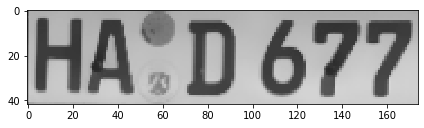

In [14]:
normalized_image = transform_image(plate_contour, img_gray)

# 4. Symbols extraction

In [15]:
def extract_plate_symbols(normalized_image, draw_result=True):
    edges = canny(normalized_image)
    edges = (edges).astype(np.uint8)
    symbols_contours = cv2.findContours(edges.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[1]

    candidates_lst = []
    candidates_coordinate = []

    # for c in symbols_contours:
    #     area = cv2.contourArea(c)
    #     print(area)
    #     if area > 70:
    #         x,y,w,h = cv2.boundingRect(c)
    #         candidates_coordinate.append(x)
    #         candidates_lst.append(normalized_image[y:y+h,x:x+w])

    biggest_contours = sorted(symbols_contours, key=lambda x: cv2.contourArea(x), reverse=True)[:6]
    for c in biggest_contours:
        x,y,w,h = cv2.boundingRect(c)
        candidates_coordinate.append(x)
        candidates_lst.append(normalized_image[y:y+h,x:x+w])

    candidates_lst = np.array(candidates_lst)
    candidates_lst = candidates_lst[np.argsort(candidates_coordinate)]
    if draw_result:
        io.imshow(candidates_lst[0])
    return candidates_lst

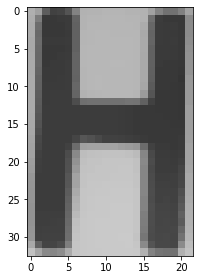

In [16]:
candidates_lst = extract_plate_symbols(normalized_image)

# 5. Features creation & Model training

## 5.1 HOG

In [17]:
classes_dict = {}
reverse_classes_dict = {}
for A, B in zip(np.concatenate([np.arange(10), list(string.ascii_lowercase)]), np.arange(36)):
    classes_dict[A] = B
    reverse_classes_dict[B] = A

X = []
y = []

train_directories_lst = os.listdir('./train_symbols/')[1:]
for symbol in train_directories_lst:
    images_lst = os.listdir('./train_symbols/{}/'.format(symbol))
    for train_img_name in images_lst:
        train_img = cv2.imread('./train_symbols/{}/{}'.format(symbol, train_img_name),cv2.IMREAD_COLOR)
        train_img = cv2.resize(train_img, (100,100))
        train_img = cv2.cvtColor(train_img, cv2.COLOR_BGR2GRAY)
        X.append(hog(train_img))
        symbol_class = classes_dict[symbol]
        y.append(symbol_class)

## 5.2 Classifier & quality metrics

In [18]:
clf = LinearSVC()
y_pred = cross_val_predict(clf, X, y, cv=KFold(5, shuffle=True))
print('Micro F1: ', f1_score(y, y_pred, average='micro'))
print('Macro F1: ', f1_score(y, y_pred, average='macro'))

Micro F1:  0.9065934065934065
Macro F1:  0.828957217089645


In [19]:
clf.fit(X, y)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

# 6. Candidates classification

In [20]:
def classify_plate_symbols(candidates_lst, clf):
    candidates_df = []

    for candidate in candidates_lst:
        candidate_upd = cv2.resize(candidate, (100,100))
        candidates_df.append(hog(candidate_upd))

    clf_answers = clf.predict(candidates_df)
    predicted_symbols = [reverse_classes_dict[ind] for ind in clf_answers]
    return predicted_symbols

In [21]:
predicted_symbols = classify_plate_symbols(candidates_lst, clf)
print(predicted_symbols)

['h', 'a', 'd', '6', '7', '7']


# 7. Let's give Tesseract a chance and compare results

In [22]:
text = pytesseract.image_to_string(normalized_image, config='--psm 8')
print("Detected number is:", text)

Detected number is: HAS D 677


# 8. Results

## 8.1 Good examples

Cool!!! I found something!
['s', 'k', '3', '4', 'c', 'k']


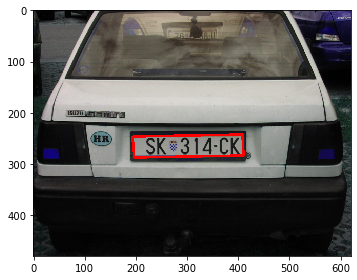

In [23]:
img_name = './baza_slika/170902/P9170014.jpg'
img_gray, img = read_and_preprocess_img(img_name, draw_result=False)
plate_contour = detect_plate_contour(img_gray, img, draw_result=True)
normalized_image = transform_image(plate_contour, img_gray, draw_result=False)
candidates_lst = extract_plate_symbols(normalized_image, draw_result=False)
predicted_symbols = classify_plate_symbols(candidates_lst, clf)
print(predicted_symbols)

In [24]:
text = pytesseract.image_to_string(normalized_image, config='--psm 8')
print("Detected number is:", text)

Detected number is: ~—6SK2#314-CK


Cool!!! I found something!
['k', 'a', '2', '7', 'c', '0']


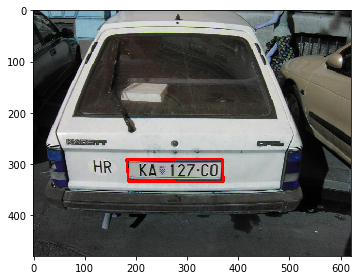

In [25]:
img_name = './baza_slika/040603/P6040055.jpg'
img_gray, img = read_and_preprocess_img(img_name, draw_result=False)
plate_contour = detect_plate_contour(img_gray, img, draw_result=True)
normalized_image = transform_image(plate_contour, img_gray, draw_result=False)
candidates_lst = extract_plate_symbols(normalized_image, draw_result=False)
predicted_symbols = classify_plate_symbols(candidates_lst, clf)
print(predicted_symbols)

In [26]:
text = pytesseract.image_to_string(normalized_image, config='--psm 8')
print("Detected number is:", text)

Detected number is: | KA=127-CO]


Cool!!! I found something!
['z', 'g', '6', '7', 'e', 'f']


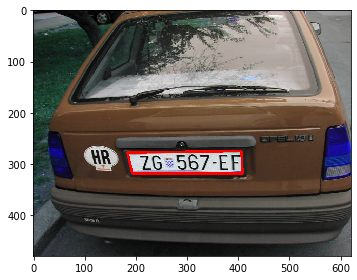

In [27]:
img_name = './baza_slika/280503/P5280085.jpg'
img_gray, img = read_and_preprocess_img(img_name, draw_result=False)
plate_contour = detect_plate_contour(img_gray, img, draw_result=True)
normalized_image = transform_image(plate_contour, img_gray, draw_result=False)
candidates_lst = extract_plate_symbols(normalized_image, draw_result=False)
predicted_symbols = classify_plate_symbols(candidates_lst, clf)
print(predicted_symbols)

In [28]:
text = pytesseract.image_to_string(normalized_image, config='--psm 8')
print("Detected number is:", text)

Detected number is: ZG #567-EF


## 8.2. Bad examples

### 1) Plate not found

Plate not found :(


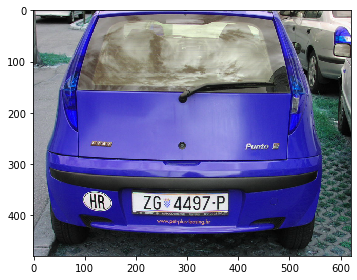

In [29]:
img_name = './baza_slika/170902/P9170015.jpg'
img_gray, img = read_and_preprocess_img(img_name, draw_result=True)
plate_contour = detect_plate_contour(img_gray, img)

### 2) Wrong plate found

Cool!!! I found something!
['s', '3', 'g', 'k', '0', 'c']


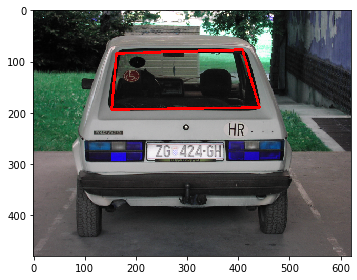

In [30]:
img_name = './baza_slika/170902/P9170032.jpg'
img_gray, img = read_and_preprocess_img(img_name, draw_result=False)
plate_contour = detect_plate_contour(img_gray, img, draw_result=True)
normalized_image = transform_image(plate_contour, img_gray, draw_result=False)
candidates_lst = extract_plate_symbols(normalized_image, draw_result=False)
predicted_symbols = classify_plate_symbols(candidates_lst, clf)
print(predicted_symbols)

### 3) Wrong symbols extraction

Cool!!! I found something!


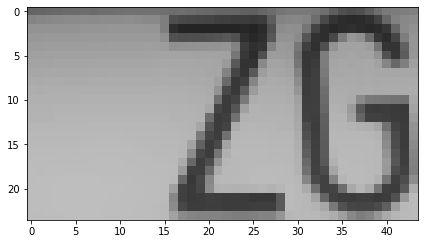

In [33]:
img_name = './baza_slika/170902/P9170030.jpg'
img_gray, img = read_and_preprocess_img(img_name, draw_result=False)
plate_contour = detect_plate_contour(img_gray, img, draw_result=False)
normalized_image = transform_image(plate_contour, img_gray, draw_result=False)
candidates_lst = extract_plate_symbols(normalized_image)

### 4) Wrong symbols classification

Cool!!! I found something!
['s', 'k', '5', '5', '3', '4']


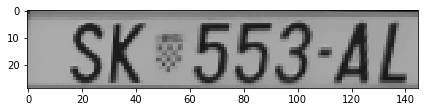

In [34]:
img_name = './baza_slika/170902/P9170023.jpg'
img_gray, img = read_and_preprocess_img(img_name, draw_result=False)
plate_contour = detect_plate_contour(img_gray, img, draw_result=False)
normalized_image = transform_image(plate_contour, img_gray, draw_result=True)
candidates_lst = extract_plate_symbols(normalized_image, draw_result=False)
predicted_symbols = classify_plate_symbols(candidates_lst, clf)
print(predicted_symbols)

# 9. Possible improvements

Our weakness is the frame plate detection. But we recognize symbols quite well, e.g. with LinearSVC we have micro F1 score $= 0.9285714285714286$.

Possible improvements:
- consider registration plate proportions
- use HOG to detect registration plate (dataset needed)
- use CNNs on each step